# Prediction of car prices based on their condition


![image](https://storage.googleapis.com/kaggle-datasets-images/1479517/2444963/1aaa3760e7dd34a87af175482c1514ae/dataset-cover.jpg?t=2021-07-21-09-56-46)

Data extracted from kaggle. Click [here](https://www.kaggle.com/datasets/sidharth178/car-prices-dataset) to see it.

## Table of Content:
1. [First view to data](#section1)
2. [Select and Train a Models](#section2)

## First view at the data <a id="section1"></a>

In [1]:
import os
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle")
    data_dir = "../input/car-prices-dataset"
else:
    print("Not running on Kaggle")
    data_dir = "archive"

Running on Kaggle


In [2]:
import numpy as np
import pandas as pd

# We already have the data partitioned
df_train = pd.read_csv(f"{data_dir}/train.csv")
print(f"Shape: {df_train.shape}")
df_train.head()

Shape: (19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df_train.isna().sum() # Below we can see the data is extremely clean; this is not common at all

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [4]:
import re

def clean(df):
    df = df.copy()
    df["Leather interior"] = df["Leather interior"].apply(lambda x: 1 if x=="Yes" else 0) # Numeric atributes are much easier to manage
    df.drop(["ID", "Levy"], axis=1, inplace=True)
    df["Engine volume"] = df["Engine volume"].apply(lambda x: float(x.split(" ")[0]))
    df["Mileage"] = df["Mileage"].apply(lambda x: float(x.split(" ")[0]))
    df["Doors"] = df["Doors"].apply(lambda x: np.int64(re.findall(r'\d+', x)[0]))
    return df

print("We have a {:.2%} of null levies".format(df_train['Levy'].apply(lambda x: x=='-').sum() / df_train.shape[0]))
print("It is very high, so we won't be using that feature")

df_train = clean(df_train)
df_train.info()

We have a 30.25% of null levies
It is very high, so we won't be using that feature
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Manufacturer      19237 non-null  object 
 2   Model             19237 non-null  object 
 3   Prod. year        19237 non-null  int64  
 4   Category          19237 non-null  object 
 5   Leather interior  19237 non-null  int64  
 6   Fuel type         19237 non-null  object 
 7   Engine volume     19237 non-null  float64
 8   Mileage           19237 non-null  float64
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Doors             19237 non-null  int64  
 13  Wheel             19237 non-null  object 
 14  Color             19237 non-null  object 
 15  Airb

In [5]:
df_train.describe()

,Price,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,0.725373,2.307990,1.532236e+06,4.582991,3.925872,6.582627
std,1.905813e+05,5.668673,0.446338,0.877805,4.840387e+07,1.199933,0.403399,4.320168
min,1.000000e+00,1939.000000,0.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000
25%,5.331000e+03,2009.000000,0.000000,1.800000,7.013900e+04,4.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,1.000000,2.000000,1.260000e+05,4.000000,4.000000,6.000000
75%,2.207500e+04,2015.000000,1.000000,2.500000,1.888880e+05,4.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,1.000000,20.000000,2.147484e+09,16.000000,5.000000,16.000000


In [6]:
import matplotlib.pyplot as plt

Y = df_train.select_dtypes(include = ["float64", "int64"])

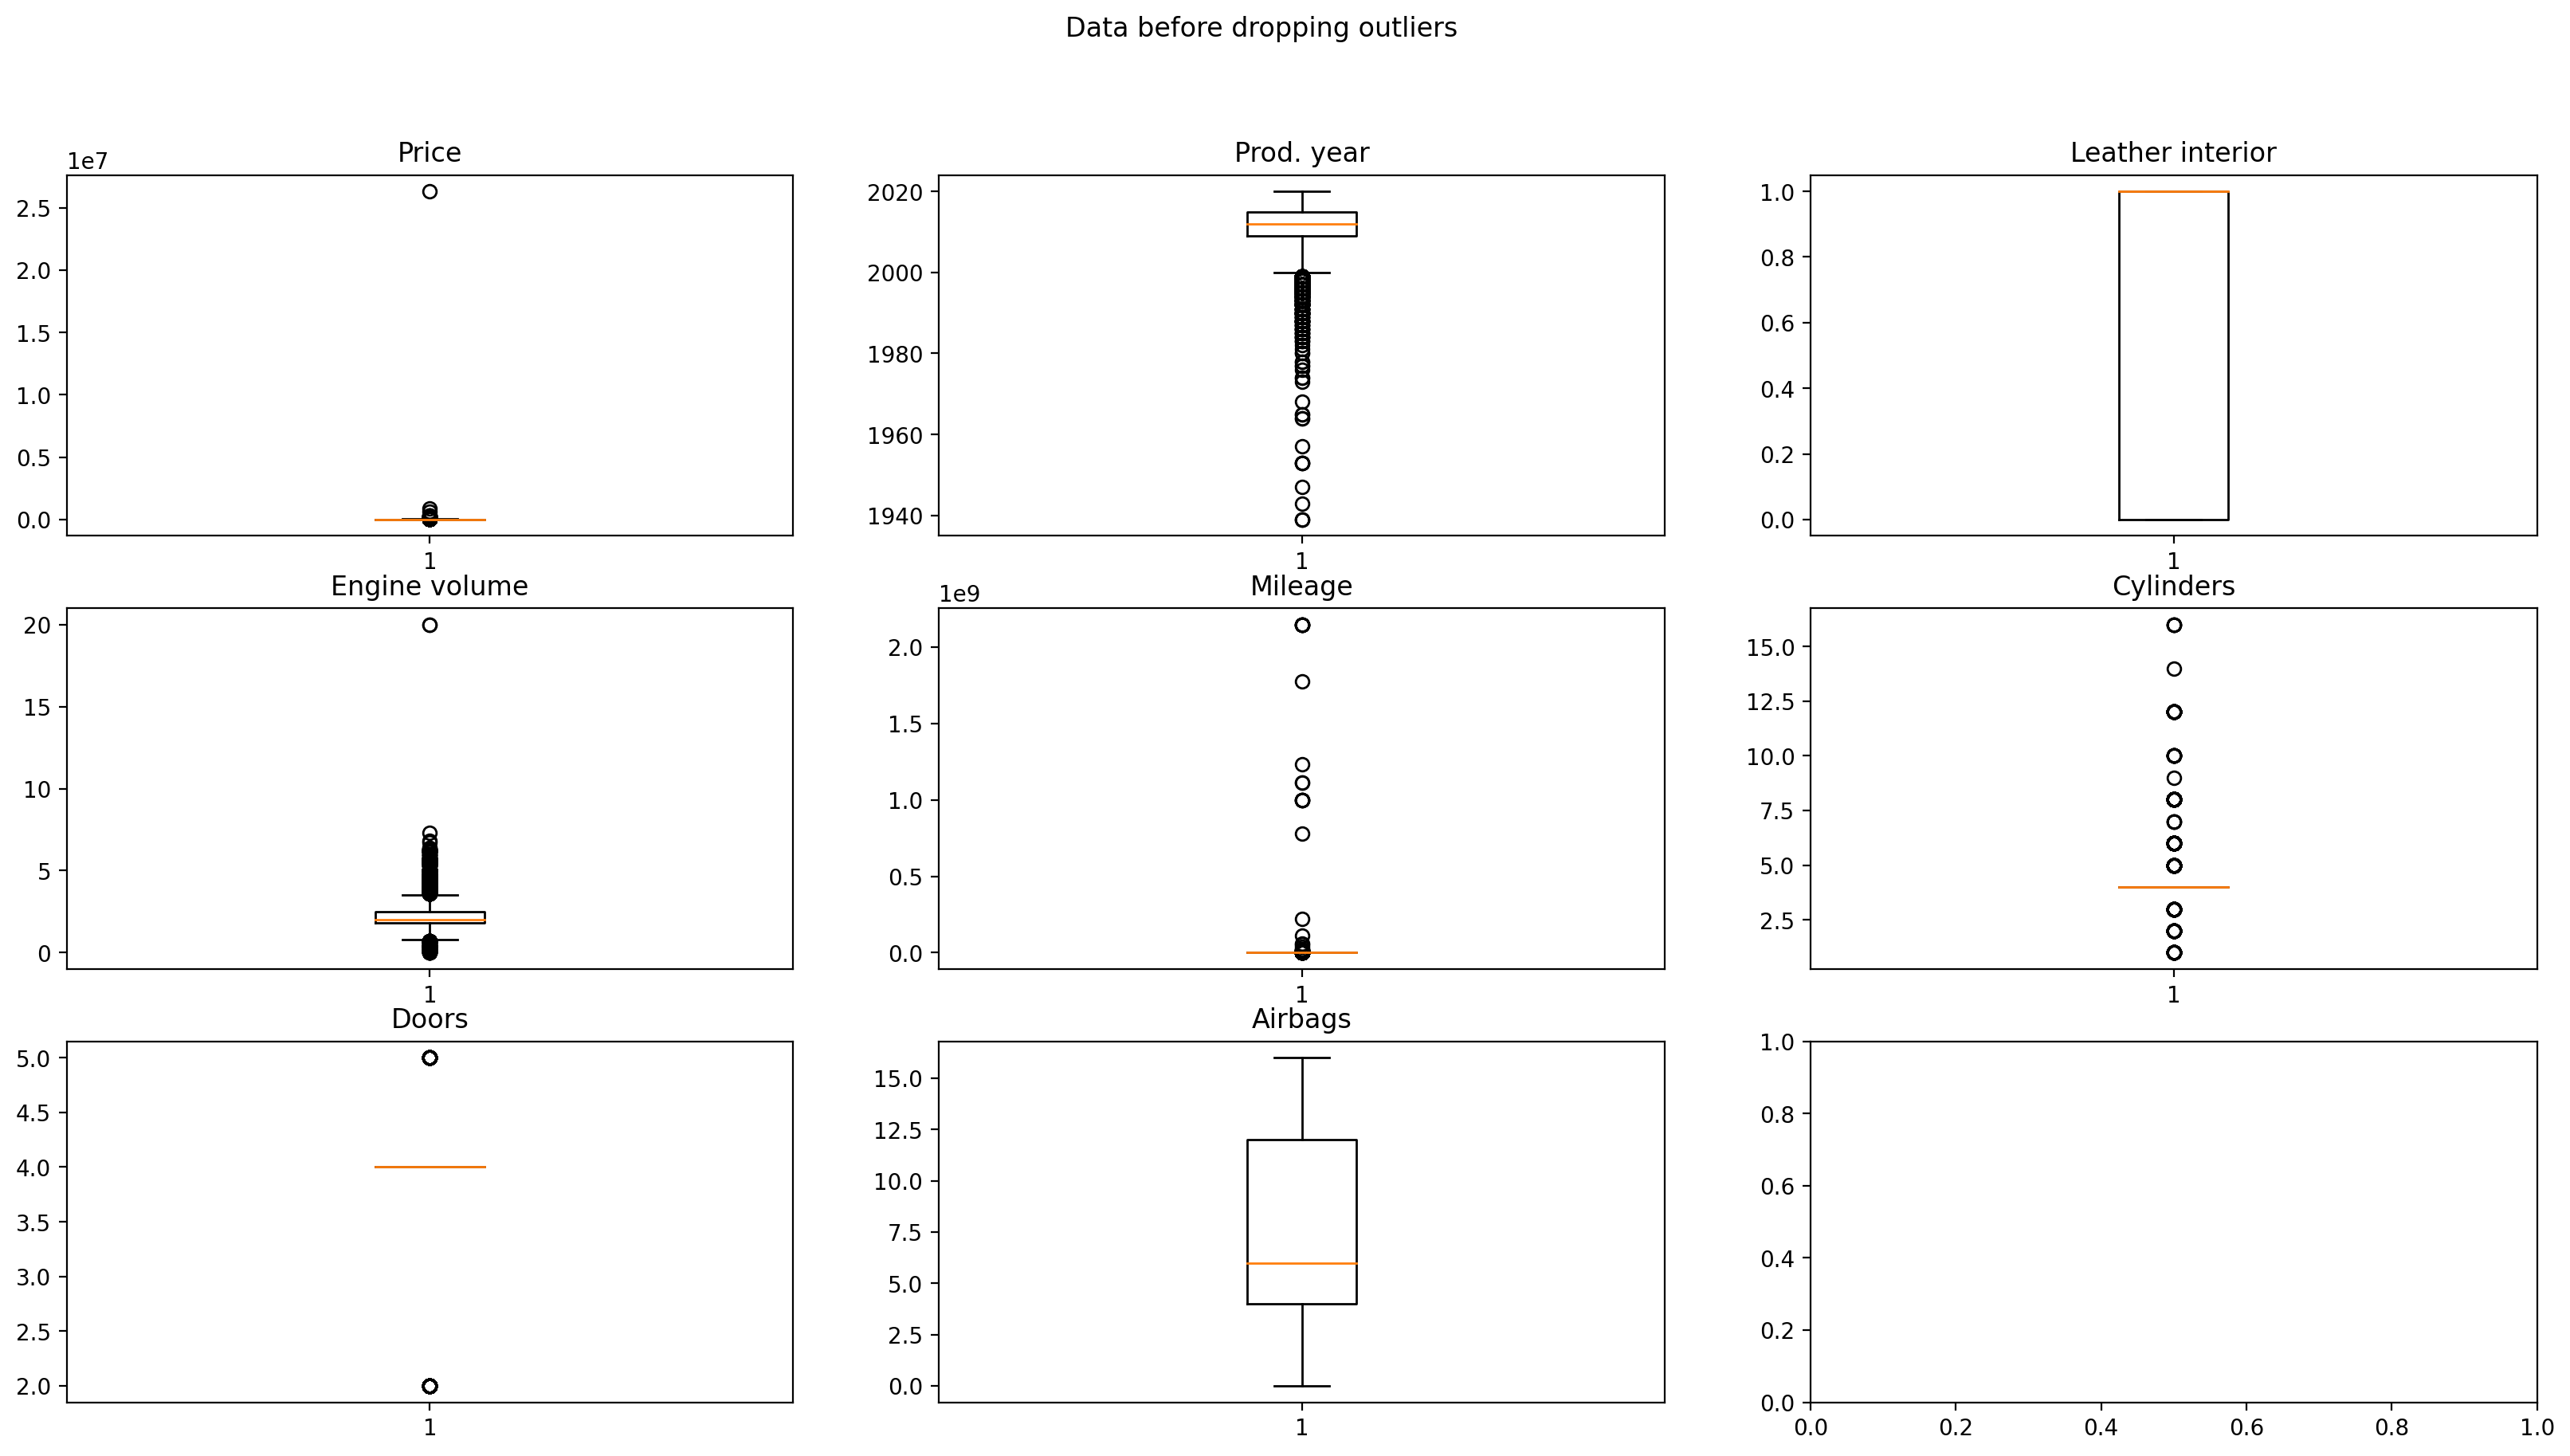

In [7]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data before dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)
for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

We can appreciate various outliers in *Price*, *Engine Volume* and a few more. Let's drop them

In [8]:
for column in ["Price", "Prod. year", "Engine volume", "Mileage"]:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df_train[column]>=upper)[0]
    lower_array = np.where(df_train[column]<=lower)[0]
    
    # Removing the outliers
    df_train.drop(index=upper_array, inplace=True)
    df_train.drop(index=lower_array, inplace=True)
    df_train.reset_index(inplace=True, drop=True)

Y = df_train.select_dtypes(include = ["float64", "int64"])

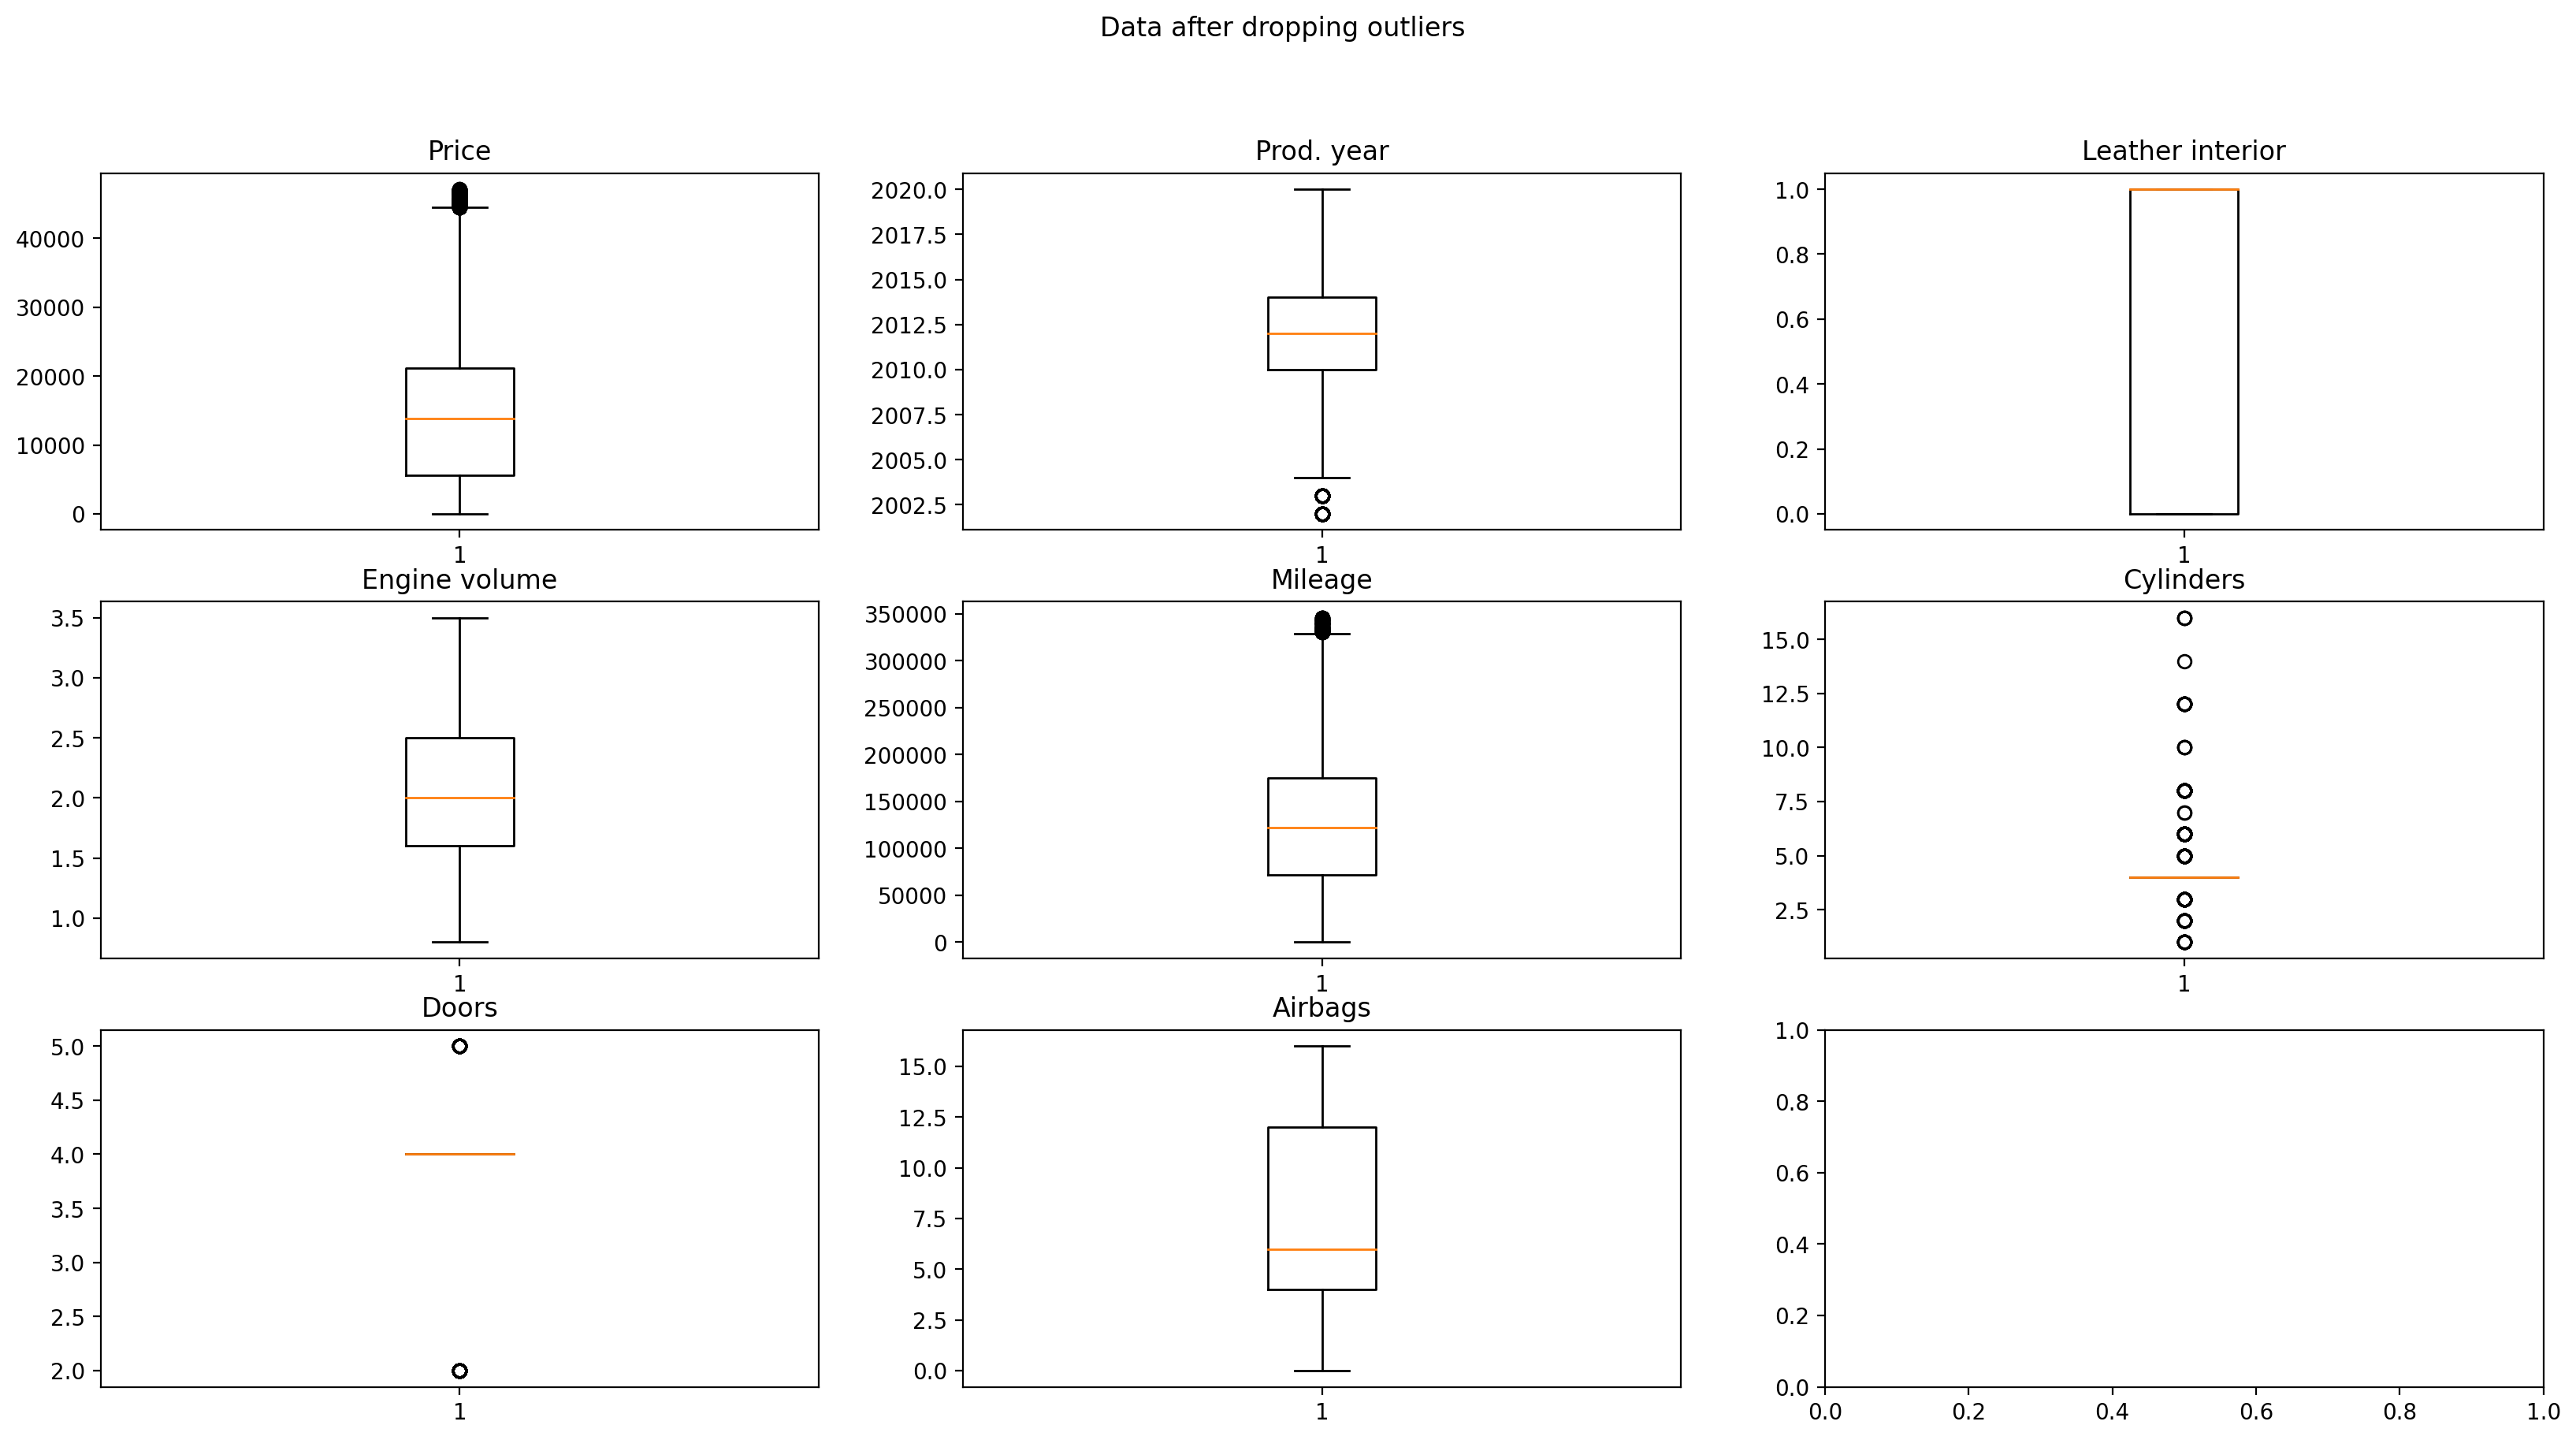

In [9]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data after dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

This already looks like a much cleaner dataset. We could drop a lot of data that seems to be outlier, but we'll use all the data for the moment and worry later

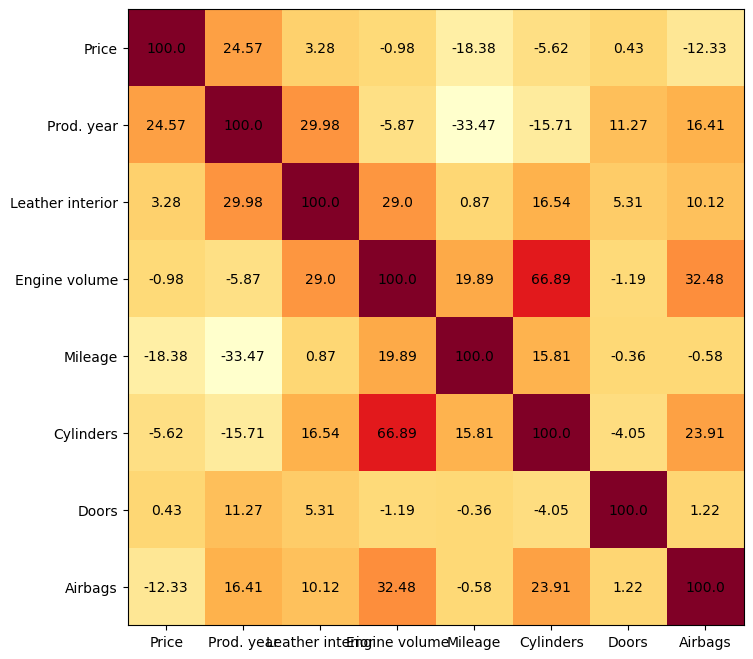

In [10]:
fig, ax = plt.subplots(figsize = (Y.shape[1], Y.shape[1]))
fig = plt.imshow(Y.corr(), cmap = "YlOrRd")
ax.set_xticks(range(Y.shape[1]))
ax.set_xticklabels(Y.axes[1])
ax.set_yticks(range(Y.shape[1]))
ax.set_yticklabels(Y.axes[1])
for (j,i),label in np.ndenumerate((Y.corr()*100).round(2)):
    ax.text(i,j,label,ha='center',va='center')
plt.show()

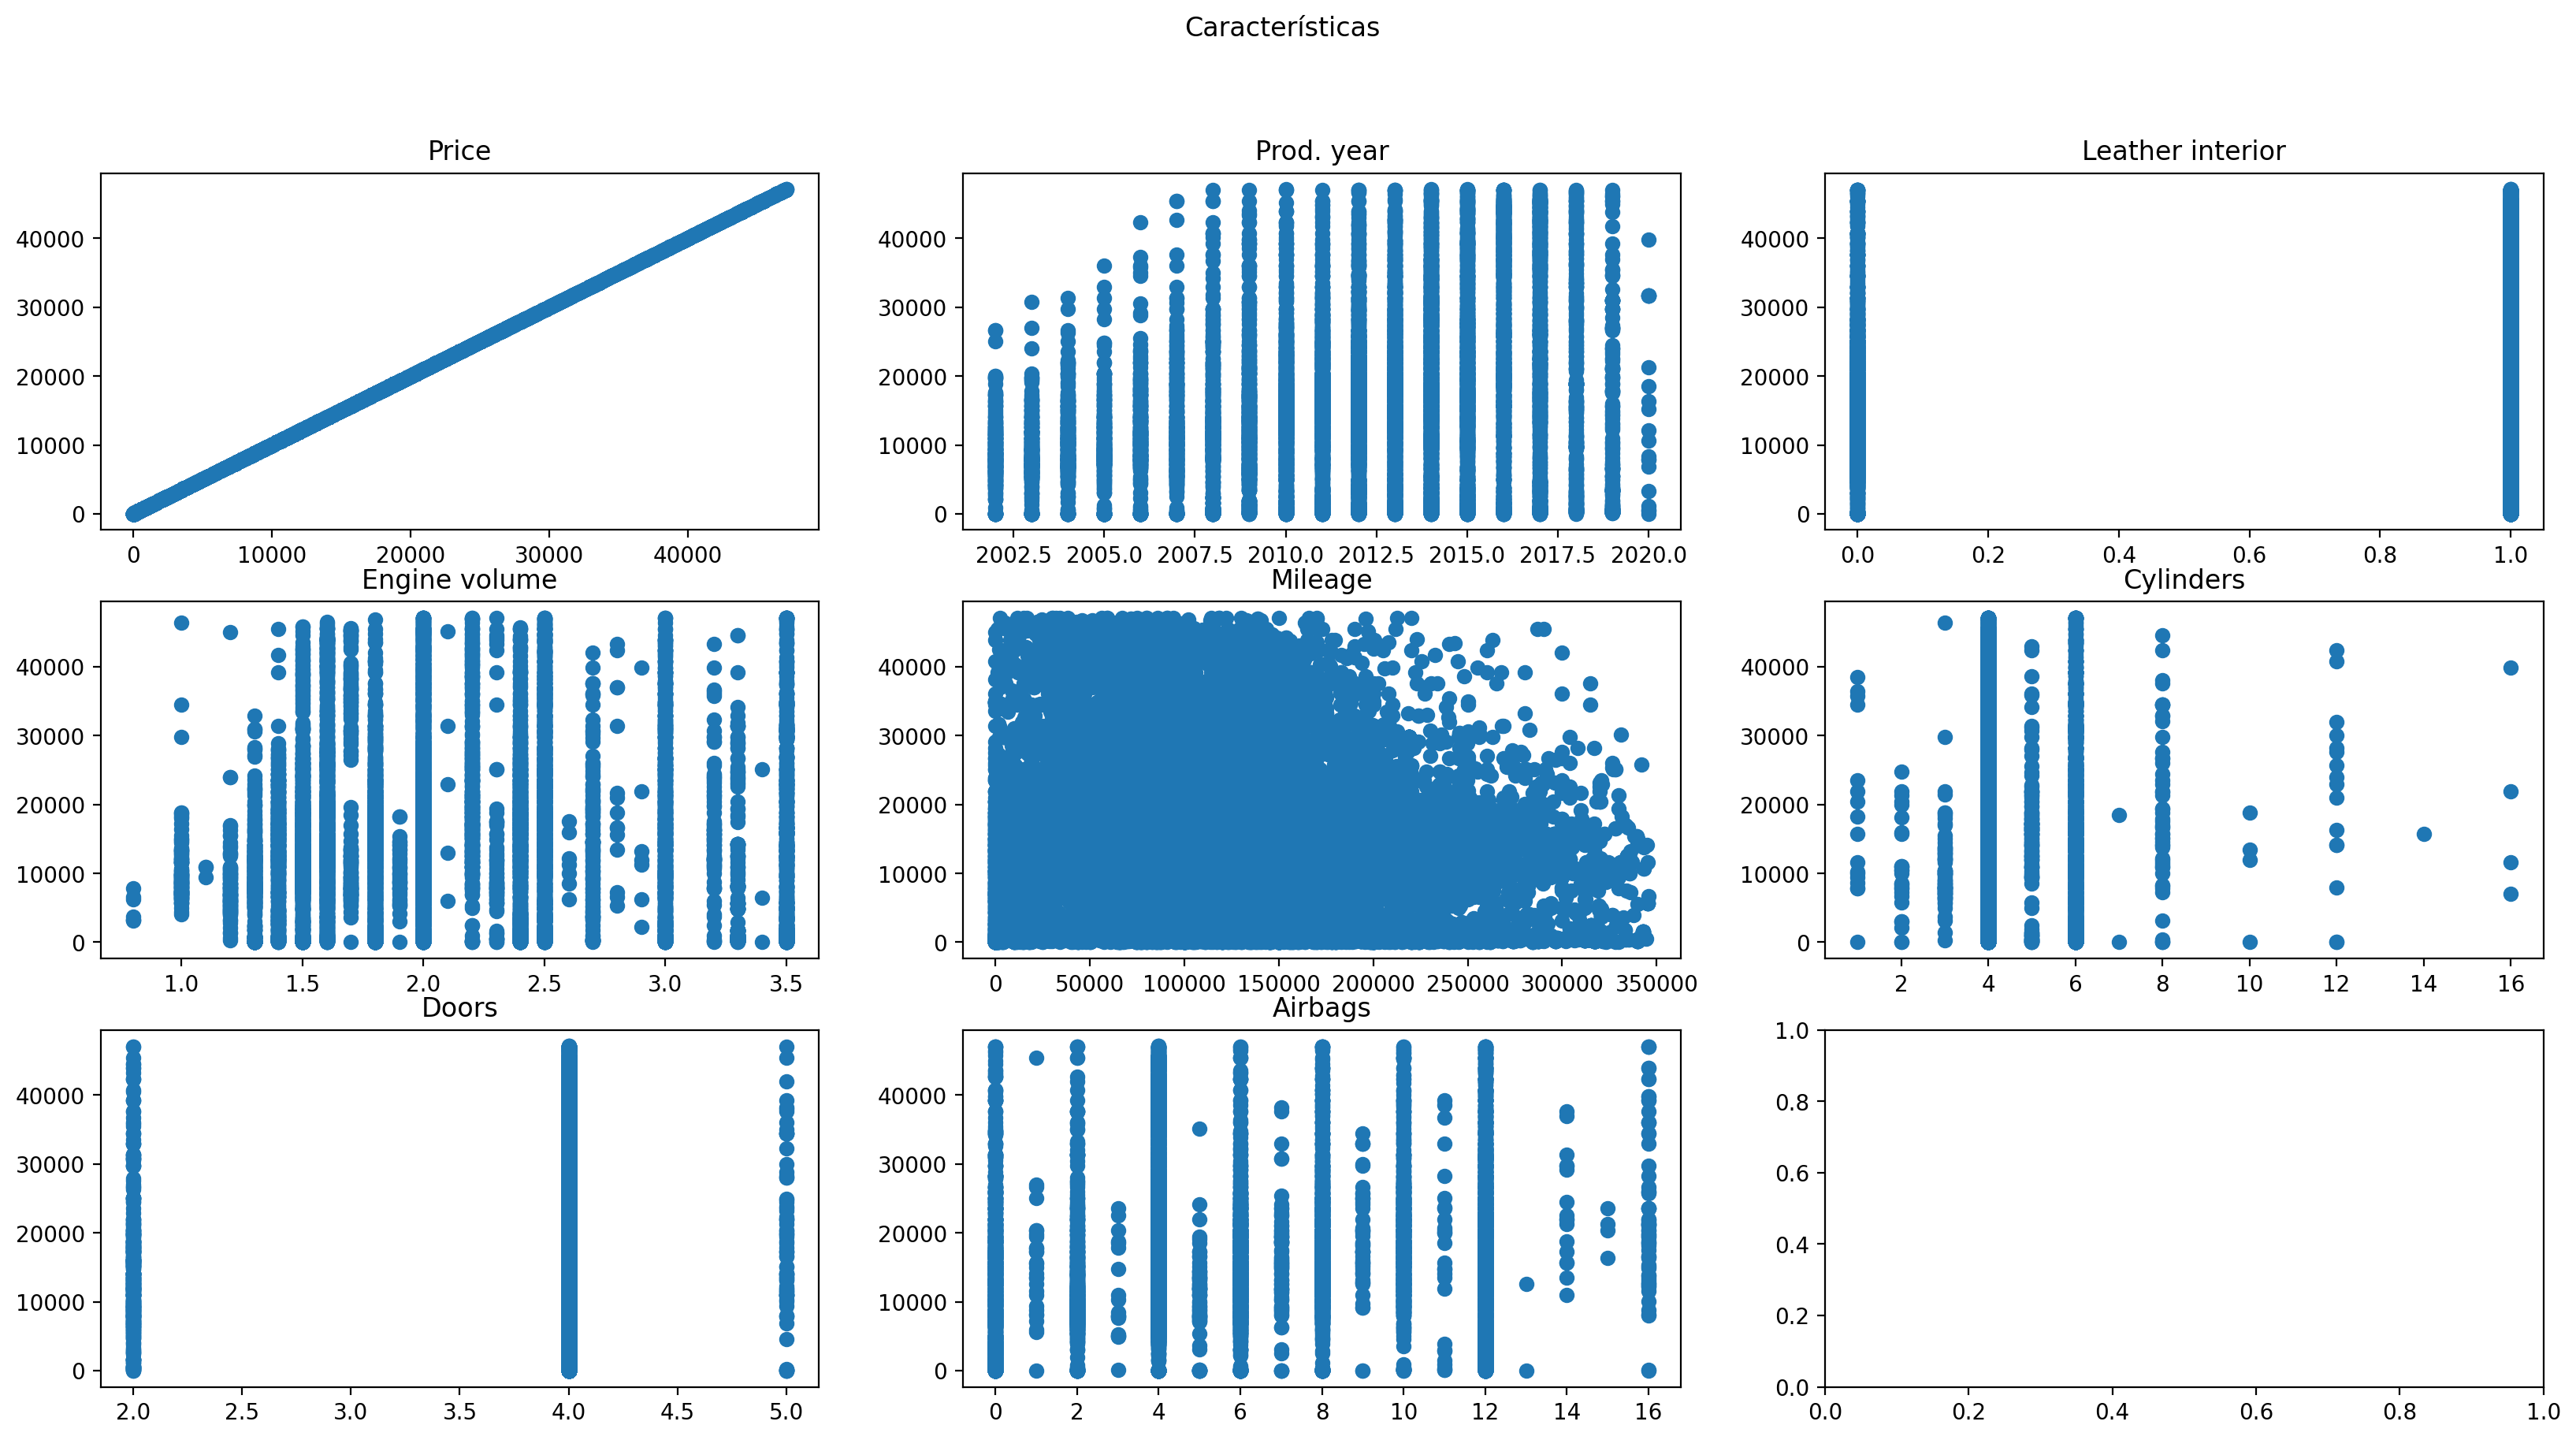

In [11]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Características")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].scatter(Y[column], Y["Price"])
    axs[int(index/3)][index%3].set_title(column)

In [12]:
X_train = df_train[df_train.columns.drop(["Price"])].copy()
Y_train = df_train["Price"].copy()
X_train

,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,LEXUS,RX 450,2010,Jeep,1,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12
1,CHEVROLET,Equinox,2011,Jeep,0,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8
2,HONDA,FIT,2006,Hatchback,0,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2
3,FORD,Escape,2011,Jeep,1,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0
4,HONDA,FIT,2014,Hatchback,1,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14939,MERCEDES-BENZ,E 350,2013,Sedan,1,Diesel,3.5,107800.0,6.0,Automatic,Rear,4,Left wheel,Grey,12
14940,HYUNDAI,Sonata,2011,Sedan,1,Petrol,2.4,161600.0,4.0,Tiptronic,Front,4,Left wheel,Red,8
14941,HYUNDAI,Tucson,2010,Jeep,1,Diesel,2.0,116365.0,4.0,Automatic,Front,4,Left wheel,Grey,4
14942,CHEVROLET,Captiva,2007,Jeep,1,Diesel,2.0,51258.0,4.0,Automatic,Front,4,Left wheel,Black,4


### We first construct the Pipeline to prepare the data

In [13]:
transf_type = {"numeric": X_train.select_dtypes(include = ["float64", "int64"]).columns,
                "cat_onehot": X_train.select_dtypes(exclude = ["float64", "int64"]).columns} # Mileage first needs to be cleaned and later treated as a numeric attribute

In [14]:
from sklearn.preprocessing import OneHotEncoder
        
onehot_encoder = OneHotEncoder()
X_train_encoded = onehot_encoder.fit_transform(X_train[transf_type["cat_onehot"]])


print(X_train_encoded.toarray())
print(f"\nShape: {X_train_encoded.shape}. That means we start working with more than 1200 dimensions.\n")
for i, j in zip(transf_type["cat_onehot"], onehot_encoder.categories_):
    print(f"{i}: {j}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Shape: (14944, 1232). That means we start working with more than 1200 dimensions.

Manufacturer: ['ACURA' 'ALFA ROMEO' 'AUDI' 'BMW' 'BUICK' 'CADILLAC' 'CHEVROLET'
 'CHRYSLER' 'CITROEN' 'DAEWOO' 'DAIHATSU' 'DODGE' 'FIAT' 'FORD' 'GAZ'
 'GMC' 'GREATWALL' 'HAVAL' 'HONDA' 'HUMMER' 'HYUNDAI' 'INFINITI' 'JAGUAR'
 'JEEP' 'KIA' 'LANCIA' 'LAND ROVER' 'LEXUS' 'LINCOLN' 'MASERATI' 'MAZDA'
 'MERCEDES-BENZ' 'MERCURY' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL' 'PEUGEOT'
 'PONTIAC' 'PORSCHE' 'RENAULT' 'SAAB' 'SATURN' 'SCION' 'SEAT' 'SKODA'
 'SSANGYONG' 'SUBARU' 'SUZUKI' 'TOYOTA' 'VAZ' 'VOLKSWAGEN' 'VOLVO' 'სხვა']
Model: ['09-Mar' '100' '100 NX' ... 'macan' 'tC' 'xD']
Category: ['Cabriolet' 'Coupe' 'Goods wagon' 'Hatchback' 'Jeep' 'Limousine'
 'Microbus' 'Minivan' 'Pickup' 'Sedan' 'Universal']
Fuel type: ['CNG' 'Diesel' 'Hybrid' 'Hydrogen' 'LPG' 'Petrol' 

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # No es necesario porque no hay nulos, pero está bien tenerlo
    ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(X_train[transf_type["numeric"]])

array([[-0.51620122,  0.59919917,  2.24701734, ...,  1.89096833,
         0.14301822,  1.20996214],
       [-0.24989435, -1.66889415,  1.42231041, ...,  1.89096833,
         0.14301822,  0.26776662],
       [-1.58142869, -1.66889415, -1.38169315, ..., -0.41378909,
         0.14301822, -1.14552666],
       ...,
       [-0.51620122,  0.59919917, -0.22710345, ..., -0.41378909,
         0.14301822, -0.6744289 ],
       [-1.31512182,  0.59919917, -0.22710345, ..., -0.41378909,
         0.14301822, -0.6744289 ],
       [ 0.01641252,  0.59919917,  0.43266209, ..., -0.41378909,
         0.14301822,  1.20996214]])

In [16]:
from sklearn.compose import ColumnTransformer
    
    
# Auxiliar pipeline for later
aux_pipeline = ColumnTransformer([
        ("num", num_pipeline, transf_type["numeric"]),
        ("cat", OneHotEncoder(), transf_type["cat_onehot"]),
    ]). fit(X_train)

def get_X_prepared(exclude_columns):
    # Erase some columns for efficient purpouses

    X_train_excluded = X_train.copy()
    X_train_excluded.drop(exclude_columns, axis=1, inplace=True)

    transf_type_excluded = transf_type.copy()
    transf_type_excluded["cat_onehot"] = transf_type["cat_onehot"].drop(labels=exclude_columns)
    
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, transf_type["numeric"]),
        ("cat", OneHotEncoder(), transf_type_excluded["cat_onehot"]),
    ])
    return full_pipeline.fit_transform(X_train_excluded)

X_prepared = get_X_prepared(["Model", "Category", "Fuel type", "Gear box type", "Drive wheels", "Color", "Manufacturer", "Wheel"])

X_prepared.shape

(14944, 7)

## Select and Train Models <a id="section2"></a>

### Polynomial Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def get_polynomial_regression(degree):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False) # degree=1 => LinearRegression
    std_scaler = StandardScaler(with_mean=False)
    lin_reg = LinearRegression()

    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    return polynomial_regression

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(ax, model, X, y, degree):
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    for m in np.arange(10000, len(x_train) + 1, step=200):
        model.fit(x_train[:m], y_train[:m]) # Many models save the previously trained part
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    ax.plot(np.arange(10000, len(x_train) + 1, step=200), np.sqrt(train_errors), "r-+", linewidth=2, label="train", scalex=200)
    ax.plot(np.arange(10000, len(x_train) + 1, step=200), np.sqrt(val_errors), "b-", linewidth=3, label="val")
    # ax.plot(np.abs(np.sqrt(train_errors)-np.sqrt(val_errors)), "grey",linewidth=3, label="diff")
    ax.legend(loc="upper right", fontsize=14)
    ax.set_title(f"RMSE, deg={degree}", fontsize=14)

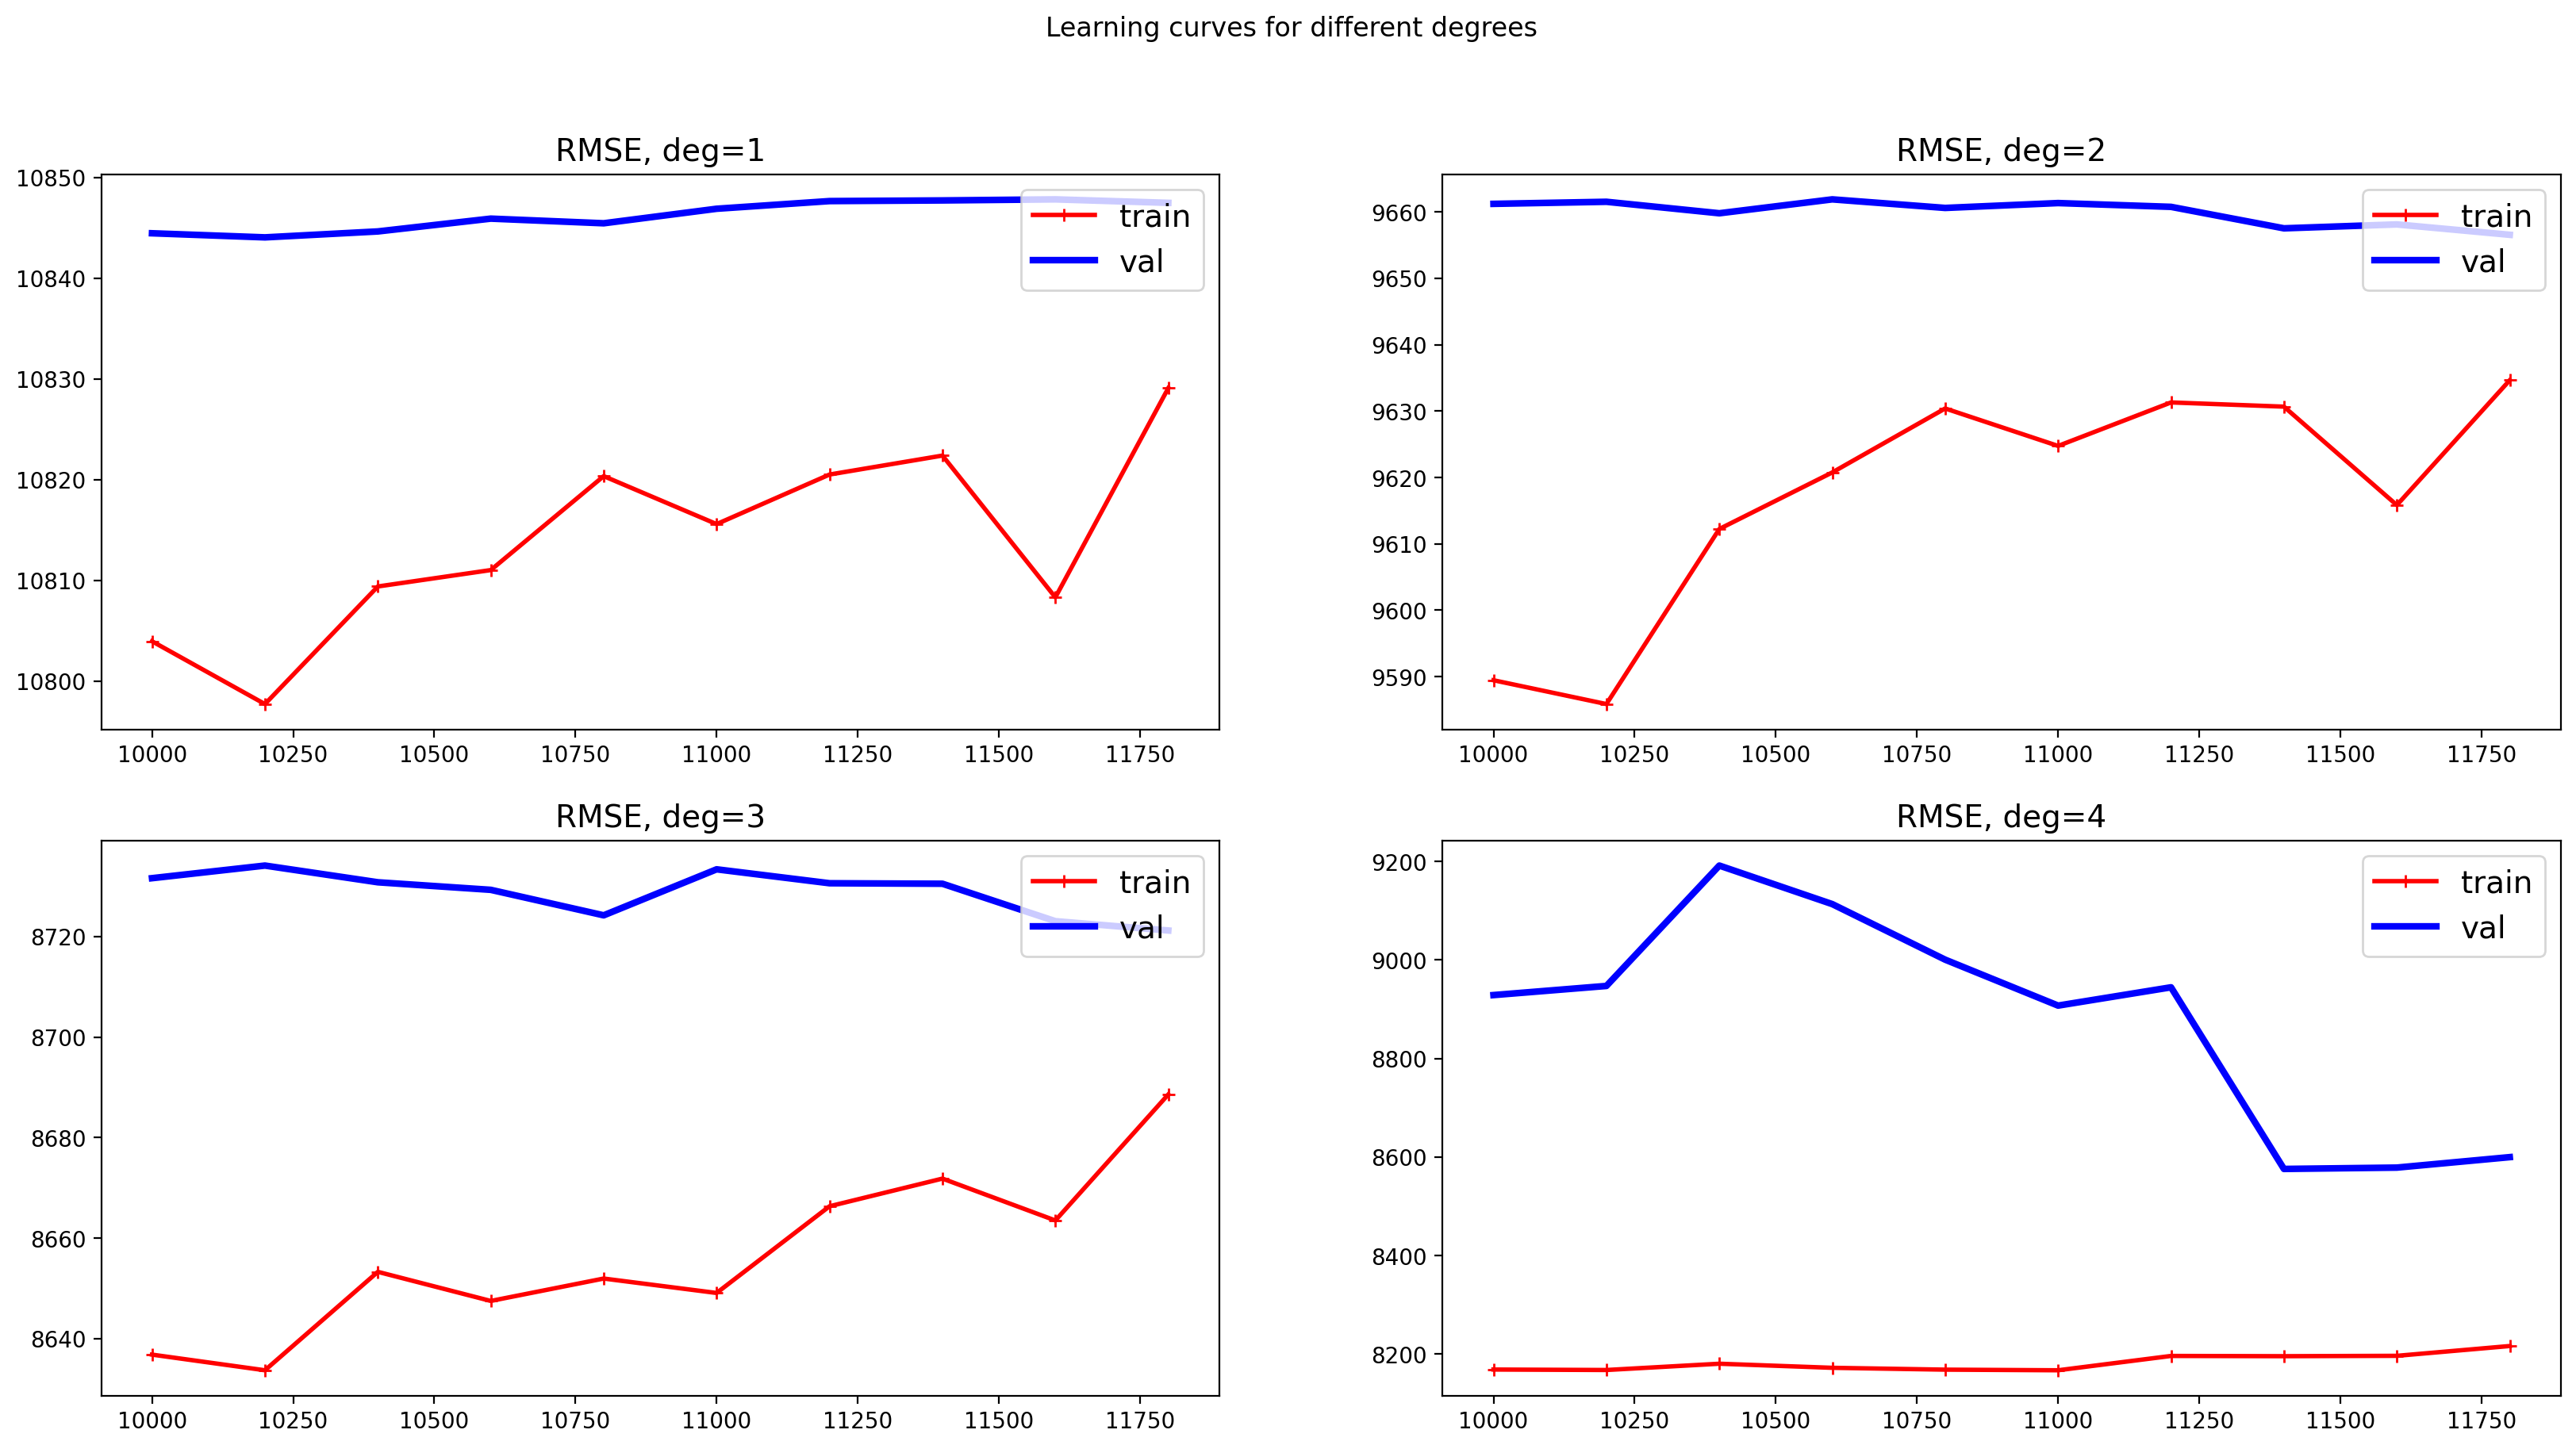

In [19]:
fig, axs = plt.subplots(2, 2)

fig.suptitle("Learning curves for different degrees")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for i, degree in zip(range(4), [1, 2, 3, 4]):
    plot_learning_curves(axs[int(i/2)][i%2], 
                         get_polynomial_regression(degree), 
                         X_prepared, Y_train, degree)

In [20]:
x_train, x_val, y_train, y_val = train_test_split(X_prepared, Y_train, test_size=0.2, random_state=42)

pol_reg = get_polynomial_regression(5).fit(x_train, y_train)

y_train_predict = pol_reg.predict(x_train)
y_val_predict = pol_reg.predict(x_val)

print(f"Train error: {np.sqrt(mean_squared_error(y_train, y_train_predict))}")
print(f"Val error: {np.sqrt(mean_squared_error(y_val, y_val_predict))}")

Train error: 7840.897871905768
Val error: 473743795234.4348


Vemos que a partir de grado 5 empieza a haber gran overfitting, por lo que es mejor tirar por otro camino.

### PCA

In [21]:
X_prepared_complete = get_X_prepared([])
X_prepared_complete.shape

(14944, 1239)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_prepared_complete_reducted = pca.fit_transform(X_prepared_complete.toarray())
pca.explained_variance_ratio_

array([0.18591941, 0.13597334, 0.08929806, 0.08331824])

In [23]:
# It is very inneficient to use a polynomial regression of high degree, but the error seems to decrease. So we will use gradient descent
from sklearn.linear_model import SGDRegressor
def get_SGDpolynomial_regression(degree):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False) # degree=1 => LinearRegression
    std_scaler = StandardScaler(with_mean=False)
    lin_reg = SGDRegressor(tol=1e-3, penalty=None, random_state=42)

    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    return polynomial_regression

Finished degree 1
Finished degree 4
Finished degree 10
Finished degree 20


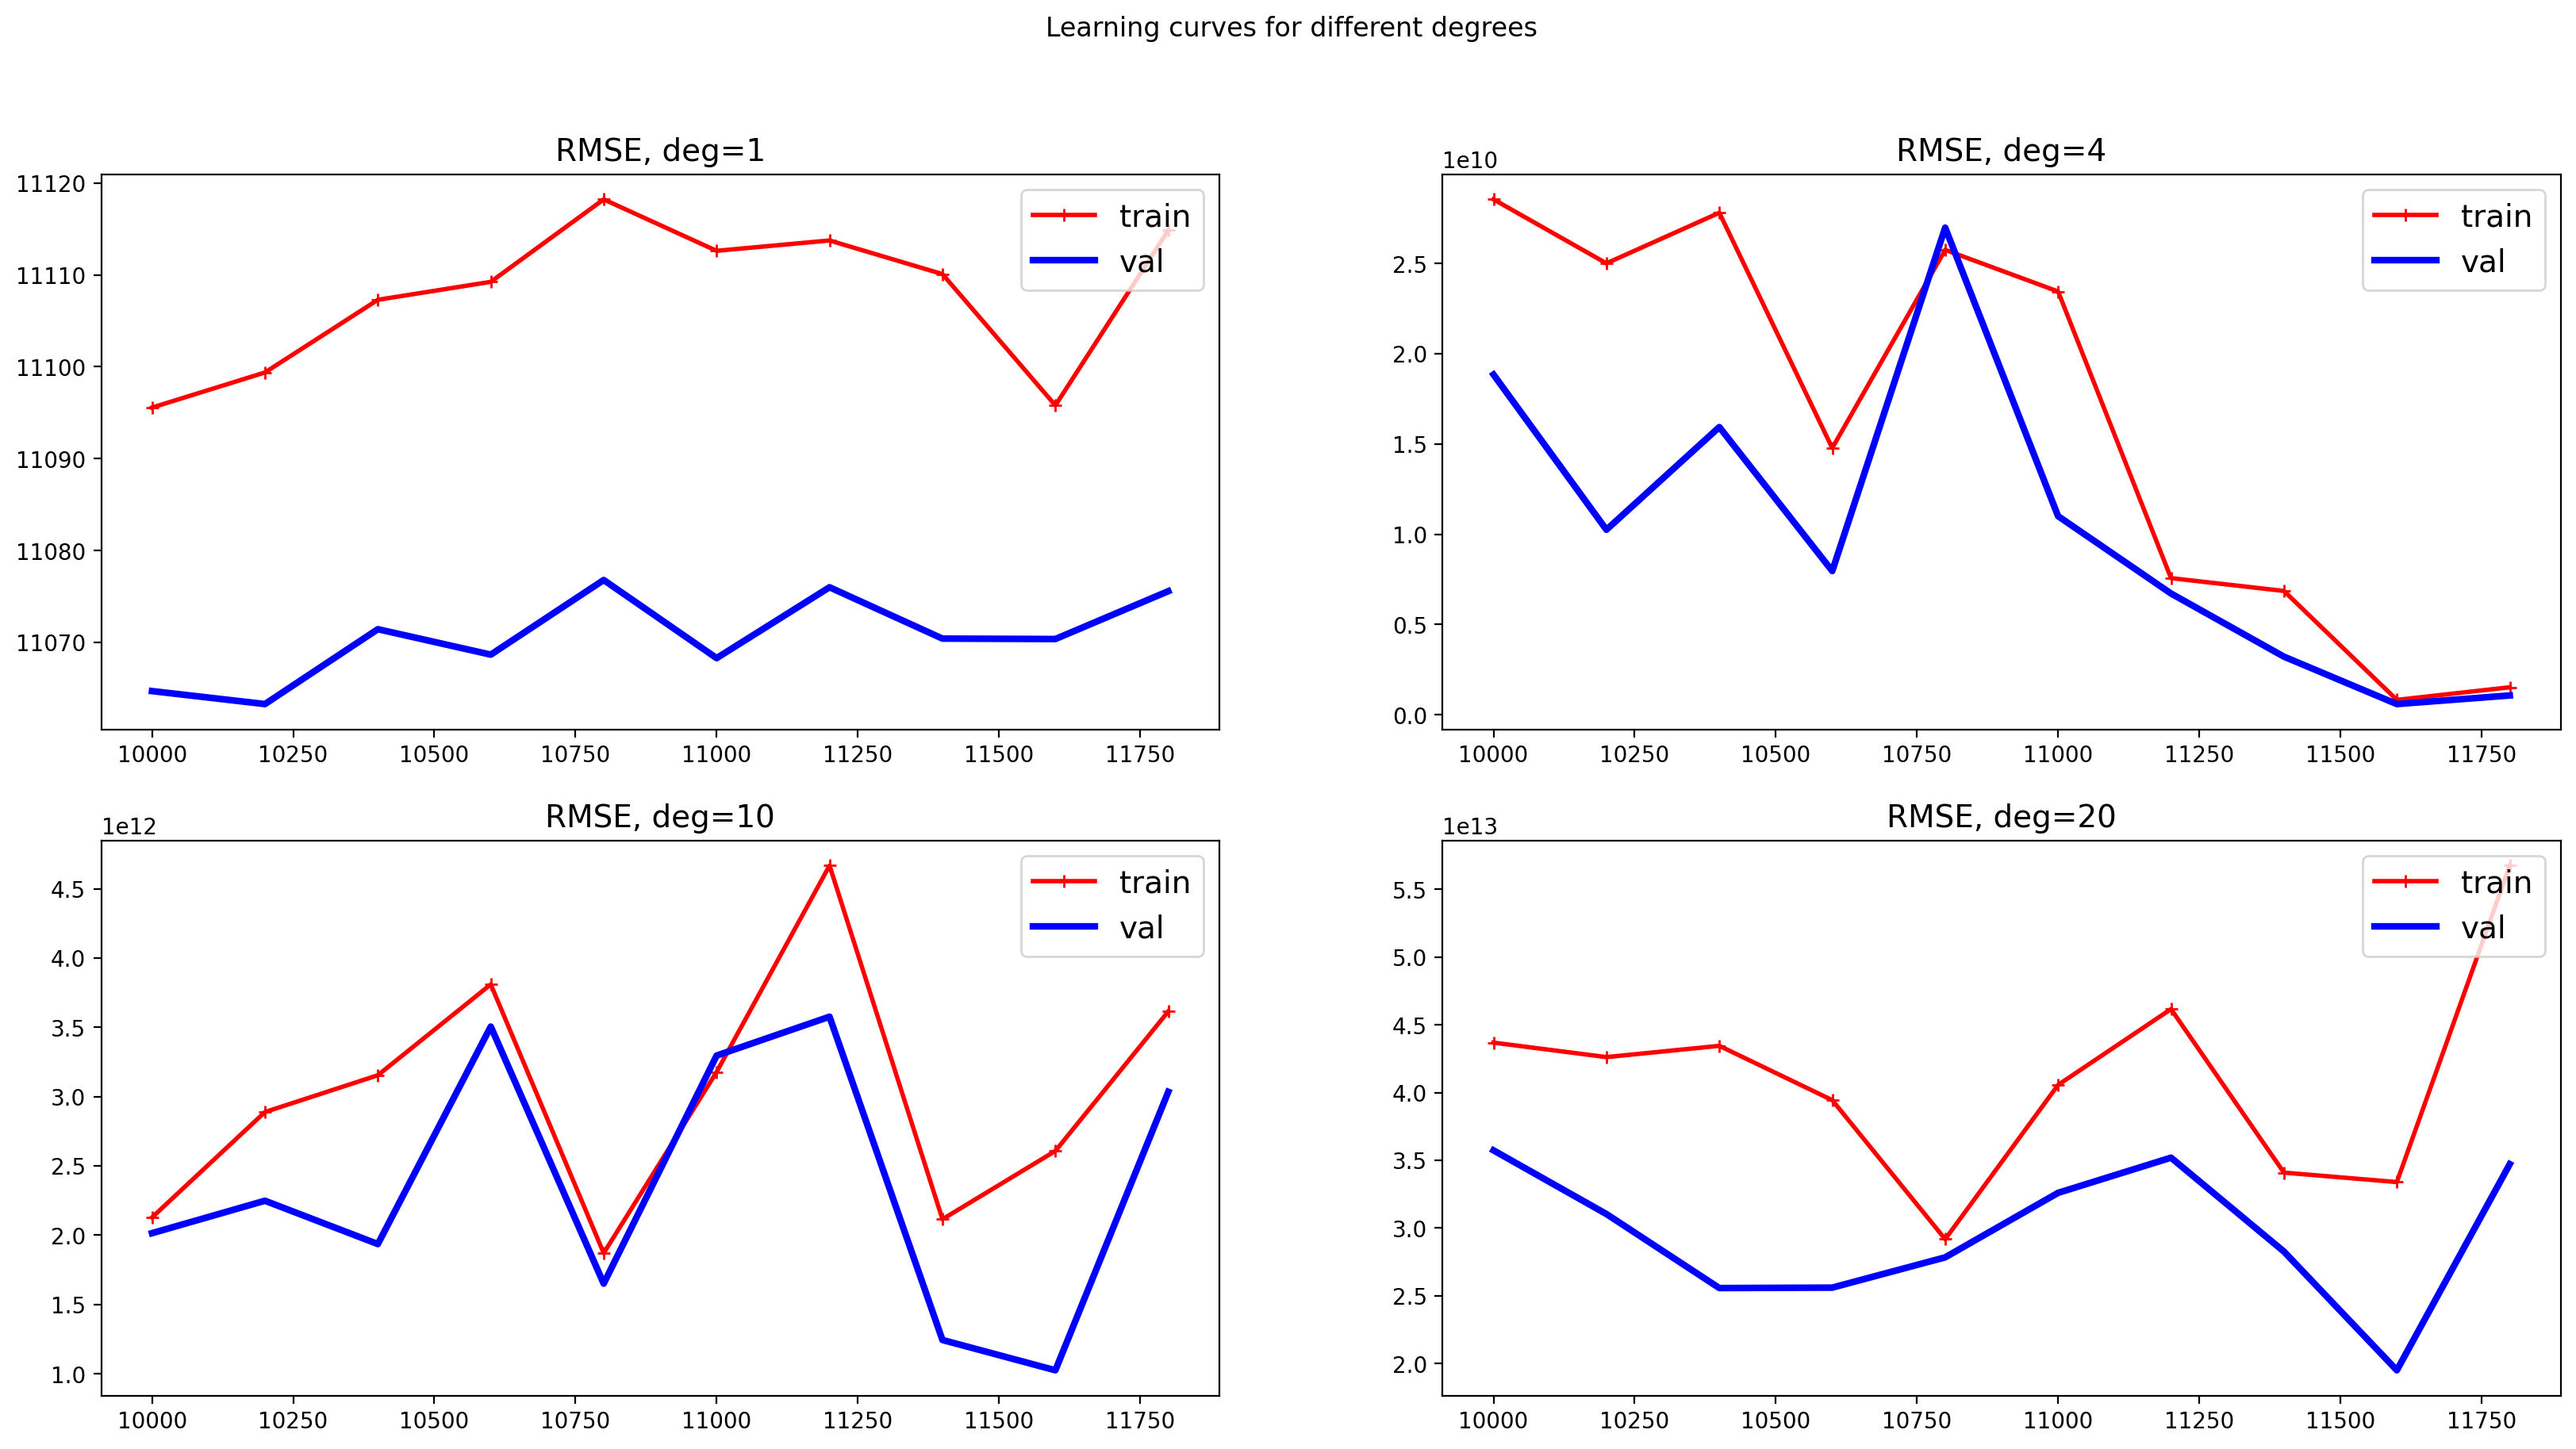

In [24]:
fig, axs = plt.subplots(2, 2)

fig.suptitle("Learning curves for different degrees")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for i, degree in zip(range(4), [1, 4, 10, 20]):
    plot_learning_curves(axs[int(i/2)][i%2], 
                         get_SGDpolynomial_regression(degree), 
                         X_prepared_complete_reducted, Y_train, degree)
    print(f"Finished degree {degree}")

In [25]:
x_train, x_val, y_train, y_val = train_test_split(X_prepared_complete_reducted, Y_train, test_size=0.2, random_state=42)

pol_reg = get_SGDpolynomial_regression(3).fit(x_train, y_train)

y_train_predict = pol_reg.predict(x_train)
y_val_predict = pol_reg.predict(x_val)

print(f"Train error: {np.sqrt(mean_squared_error(y_train, y_train_predict))}")
print(f"Val error: {np.sqrt(mean_squared_error(y_val, y_val_predict))}")

Train error: 9907.63647184245
Val error: 9836.151926864908


With degrees > 3, we can not get better results. <br>
At the moment, classic Linear Regression is our best aproach. <br>
Let's try more advanced models. <br>

In [26]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


def model(features,target,Test,random,scaler,n,maxd):
    x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=Test, random_state=random)
    x_train = scaler.fit_transform(x_train) 
    x_test = scaler.fit_transform(x_test)
    
    print('Size Split Train:',x_train.shape, x_test.shape)
    print('Size Split Test:', y_train.shape, y_test.shape)
    print()
    print()
    
    regression = {
        'DECISION':DecisionTreeRegressor(max_depth=maxd),
        'FOREST':RandomForestRegressor(n_estimators=n, max_depth=maxd),
        'GRADIENT':GradientBoostingRegressor(n_estimators=n,max_depth=maxd),
        'EXTRA':ExtraTreesRegressor(n_estimators=n,max_depth=maxd)
    }
    
    for nome, model in regression.items():
        print('-><-'*20)
        print('Nome:', nome)
        
        model.fit(x_train, y_train)
        y_pred = model.predict(x_train)
        print('Train Score:', model.score(x_train, y_train))
        print('Test Score:', model.score(x_test, y_test))

        plt.scatter(y_train, y_pred, c='green')
        plt.plot([y_train.min(), y_train.max()], [y_train.min(),y_train.max()], c='blue')
        plt.xlabel('Current Value')
        plt.ylabel('Predicted Value')
        plt.show()
print('ok')

ok


Size Split Train: (11955, 4) (2989, 4)
Size Split Test: (11955,) (2989,)


-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: DECISION
Train Score: 0.9662322445500247
Test Score: 0.18767720665804555


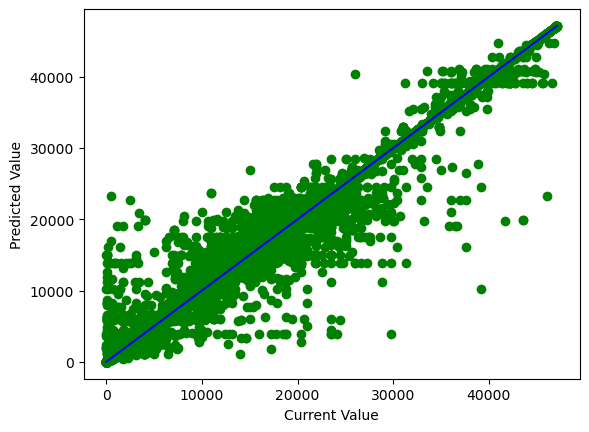

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: FOREST
Train Score: 0.9336840066457369
Test Score: 0.5743378346271406


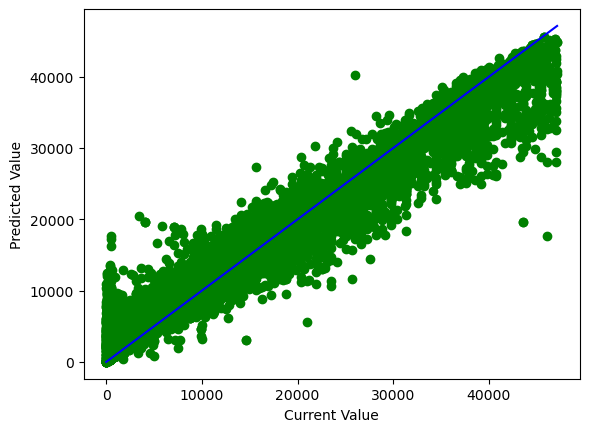

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: GRADIENT
Train Score: 0.9954628204888233
Test Score: 0.3593868503143376


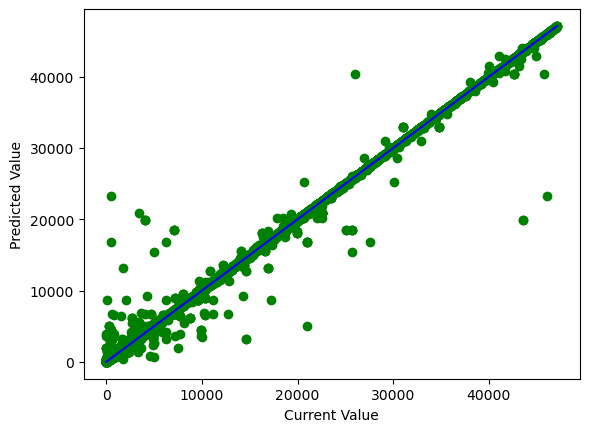

-><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><--><-
Nome: EXTRA
Train Score: 0.9702770709915193
Test Score: 0.5993993164773603


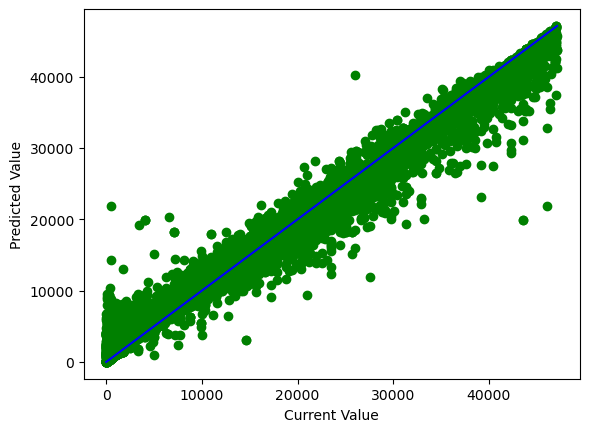

In [27]:
model(X_prepared_complete_reducted, Y_train, 0.2, 42,num_pipeline,70, 20)

In [28]:
final_model = GradientBoostingRegressor(n_estimators=72,max_depth=20)
final_model.fit(X_prepared_complete_reducted, Y_train)

GradientBoostingRegressor(max_depth=20, n_estimators=72)

## Final Test

We should do it with the test dataset, but it comes without Price.

In [29]:
df_test = pd.read_csv(f"{data_dir}/train.csv")
samples = df_test.sample(10, random_state=0)
X = samples.drop("Price", axis=1)

In [30]:
X = clean(X)

In [31]:
def get_X_prepared(exclude_columns=[]):
    # Erase some columns for efficient purpouses

    samples_excluded = X.copy()
    samples_excluded.drop(exclude_columns, axis=1, inplace=True)

    return aux_pipeline.transform(samples_excluded)

X = get_X_prepared()


In [32]:
X = pca.transform(X.toarray())

predicted_prices = final_model.predict(X)

In [33]:
real_price = samples["Price"]
samples.drop("Price", axis=1, inplace=True)

samples["Real Price"] = real_price.astype(int)
samples["Predicted Price"] = predicted_prices.astype(int)
samples["Difference"] = samples["Real Price"] - samples["Predicted Price"]

Las siguientes tablas son para intentar predecir precios y apreciar lo bueno que es nuestro modelo

In [34]:
samples.drop(["Predicted Price", "Real Price", "Difference"], axis=1)

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
15458,45808894,583,CHEVROLET,Aveo,2011,Sedan,Yes,Petrol,1.6,125837 km,4.0,Automatic,Front,04-May,Left wheel,Black,4
15175,45520010,779,TOYOTA,Avalon,2013,Sedan,Yes,Hybrid,2.5,51543 km,4.0,Tiptronic,Front,04-May,Left wheel,Silver,12
9132,45768913,583,KIA,RIO,2011,Sedan,Yes,Petrol,1.6,0 km,4.0,Automatic,Front,04-May,Left wheel,Silver,12
10435,45798512,-,OPEL,Astra,1998,Goods wagon,No,Diesel,1.7,55000 km,4.0,Manual,Front,04-May,Left wheel,Green,2
3249,45645743,607,TOYOTA,Camry,2019,Sedan,Yes,Hybrid,2.5,39552 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
16972,45652429,1058,MERCEDES-BENZ,ML 350,2012,Jeep,Yes,Diesel,3.5,245762 km,6.0,Automatic,4x4,04-May,Left wheel,Black,12
15747,45801517,730,HYUNDAI,Elantra,2016,Sedan,Yes,LPG,1.6,138241 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
11389,45813225,585,HYUNDAI,Elantra,2013,Sedan,Yes,Petrol,1.8,230746 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
3335,45813697,574,HONDA,Civic,2010,Sedan,Yes,Hybrid,1.3,264132 km,4.0,Automatic,Front,04-May,Left wheel,Silver,12
9267,45756469,-,MAZDA,MPV,2004,Minivan,No,Petrol,2.3,272000 km,4.0,Automatic,4x4,04-May,Right-hand drive,Red,0


In [35]:
samples

,ID,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Real Price,Predicted Price,Difference
15458,45808894,583,CHEVROLET,Aveo,2011,Sedan,Yes,Petrol,1.6,125837 km,4.0,Automatic,Front,04-May,Left wheel,Black,4,10697,10704,-7
15175,45520010,779,TOYOTA,Avalon,2013,Sedan,Yes,Hybrid,2.5,51543 km,4.0,Tiptronic,Front,04-May,Left wheel,Silver,12,42337,42200,137
9132,45768913,583,KIA,RIO,2011,Sedan,Yes,Petrol,1.6,0 km,4.0,Automatic,Front,04-May,Left wheel,Silver,12,314,349,-35
10435,45798512,-,OPEL,Astra,1998,Goods wagon,No,Diesel,1.7,55000 km,4.0,Manual,Front,04-May,Left wheel,Green,2,2800,18111,-15311
3249,45645743,607,TOYOTA,Camry,2019,Sedan,Yes,Hybrid,2.5,39552 km,4.0,Automatic,Front,04-May,Left wheel,Black,12,251,259,-8
16972,45652429,1058,MERCEDES-BENZ,ML 350,2012,Jeep,Yes,Diesel,3.5,245762 km,6.0,Automatic,4x4,04-May,Left wheel,Black,12,157,165,-8
15747,45801517,730,HYUNDAI,Elantra,2016,Sedan,Yes,LPG,1.6,138241 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4,21395,21393,2
11389,45813225,585,HYUNDAI,Elantra,2013,Sedan,Yes,Petrol,1.8,230746 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12,706,706,0
3335,45813697,574,HONDA,Civic,2010,Sedan,Yes,Hybrid,1.3,264132 km,4.0,Automatic,Front,04-May,Left wheel,Silver,12,470,498,-28
9267,45756469,-,MAZDA,MPV,2004,Minivan,No,Petrol,2.3,272000 km,4.0,Automatic,4x4,04-May,Right-hand drive,Red,0,1700,1722,-22


# License

This Jupyter Notebook and its contents are licensed under the terms of the GNU General Public License Version 2 as published by the Free Software Foundation. The full text of the license can be found at: https://www.gnu.org/licenses/gpl-2.0.html

Copyright (c) 2023, Joaquín Mateos Barroso

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/ for a list of additional licenses.